In [38]:
from geojson import FeatureCollection, Feature
import http.client
import pandas as pd
import numpy as np
import requests
import json
import geopandas as gpd
from datetime import datetime
import io
from IPython.display import Image

In [54]:
# input MnDOT sample
cd = "Z:/Data/Users/Sijia/Met_Council/GIS/sample/"

mn_input_gdf = gpd.read_file(cd + "mndot_trans_lanes.shp")

In [31]:
# function to prepare API request
def shp_to_json(input_gdf):
    
    input_gdf_latlon = input_gdf.copy()
    input_gdf_latlon = input_gdf_latlon[input_gdf_latlon.geometry.notnull()]
    
    #input_gdf_latlon['geometry'] = input_gdf_latlon['geometry'].apply(lambda g: LineString([xy[0:2] for xy in list(g.coords)]))
    
    input_gdf_latlon = input_gdf_latlon.to_crs({'init': 'epsg:4326'})
    
    obj_list = [x for x in input_gdf_latlon.columns.values if (input_gdf_latlon[x].dtype == object)&(x!='geometry')]
    for x in obj_list:
        input_gdf_latlon[x] = input_gdf_latlon[x].str.replace('\'', '')
        input_gdf_latlon[x] = input_gdf_latlon[x].str.replace('\"', '')
    
    input_gdf_latlon.fillna(0, inplace = True)
        
    input_json = json.loads(input_gdf_latlon.to_json())
    
    return input_json['features']


def match_geom(input_json):
    
    conn = http.client.HTTPSConnection("api.sharedstreets.io")    
    fc = {"type":"FeatureCollection", "features":input_json}
    payload = str(fc).replace('\'', '\"')
    
    headers = {"content-type": "application/json"}

    conn.request("POST", 
                     "/v0.1.0/match/geoms?authKey=bdd23fa1-7ac5-4158-b354-22ec946bb575", 
                     payload, 
                     headers)

    res = conn.getresponse()
    return_data = res.read()
    
    return_json = json.loads(return_data.decode('utf-8'))
    
    return return_json

In [55]:
mndot_input_json = shp_to_json(mn_input_gdf)

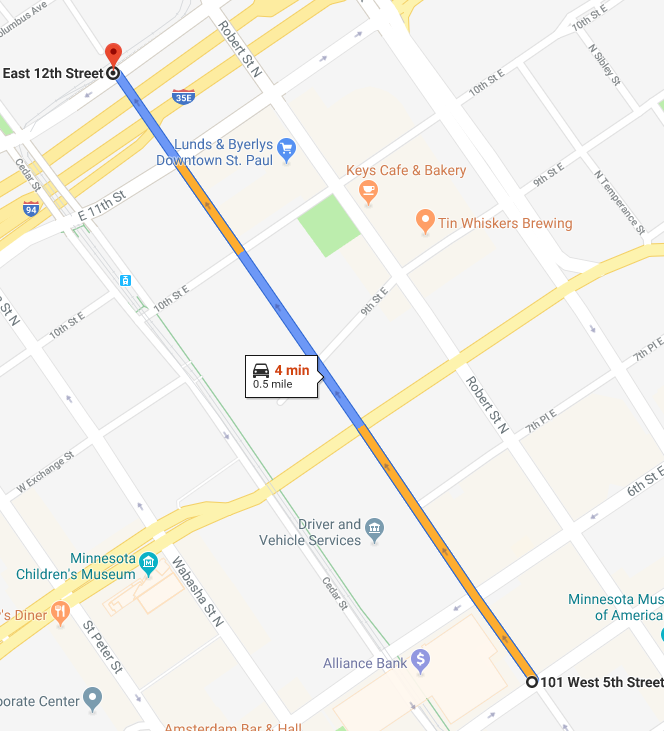

{'matched': {'type': 'FeatureCollection',
  'features': [{'type': 'Feature',
    'properties': {'referenceId': 'd87cb60b621dcf6b880ce93ec1506c27',
     'fromIntersectionId': 'c97b7d4636d88b8dd85cfb12b14c0ad3',
     'toIntersectionId': 'f83afe8007accd79cfa22542184505af',
     'roadClass': 'Residential',
     'direction': 'forward',
     'geometryId': '3b43bd296528b33cdb2f1bc886fbb67c',
     'referenceLength': 108.34,
     'section': [1.4300964056872227, 108.34],
     'side': 'right',
     'score': 6.310232231683709,
     'originalFeature': {'id': '3',
      'type': 'Feature',
      'properties': {'ROUTE_ID': '1000023965112248-I',
       'THROUGH_LA': 2,
       'SHAPE_Leng': 634.373258125},
      'geometry': {'type': 'LineString',
       'coordinates': [[-93.09280640980054, 44.94768425898016],
        [-93.09361468869884, 44.9485162851479],
        [-93.09425117510341, 44.94917290823412],
        [-93.09484284532704, 44.94978005388786],
        [-93.0958345205513, 44.950796452693396],
  

In [56]:
# successful example: downtown St Pual
# source: MnDOT
# Minnesota St between 5th St and 12th St
display(Image(filename = cd + "example1.PNG", height=800, width=600))

return_json = match_geom(mndot_input_json[3])
return_json

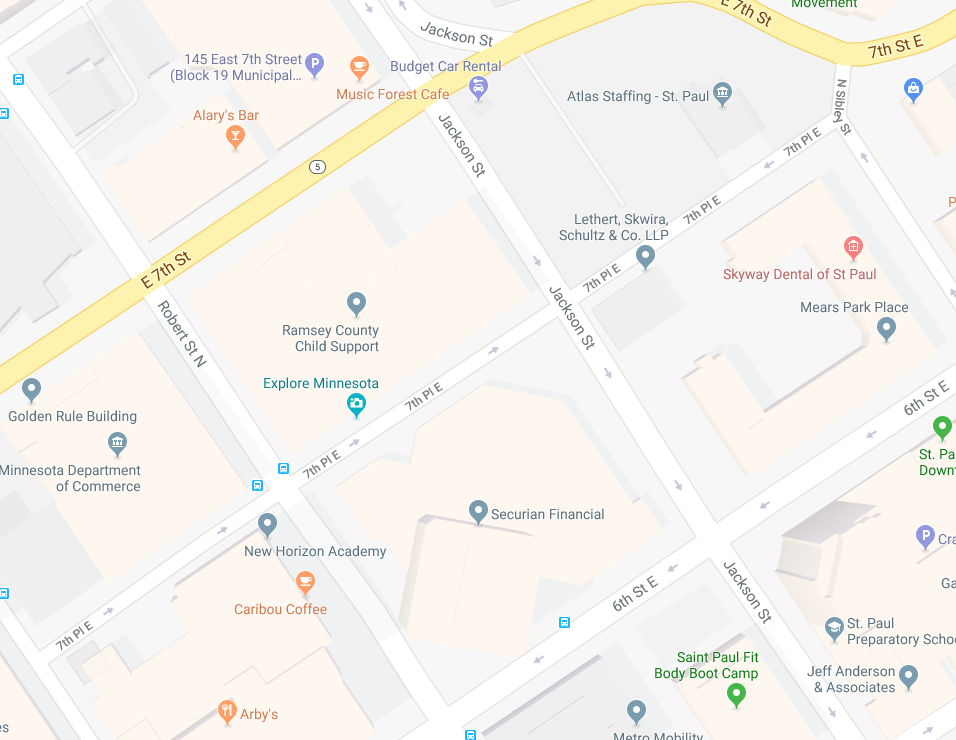

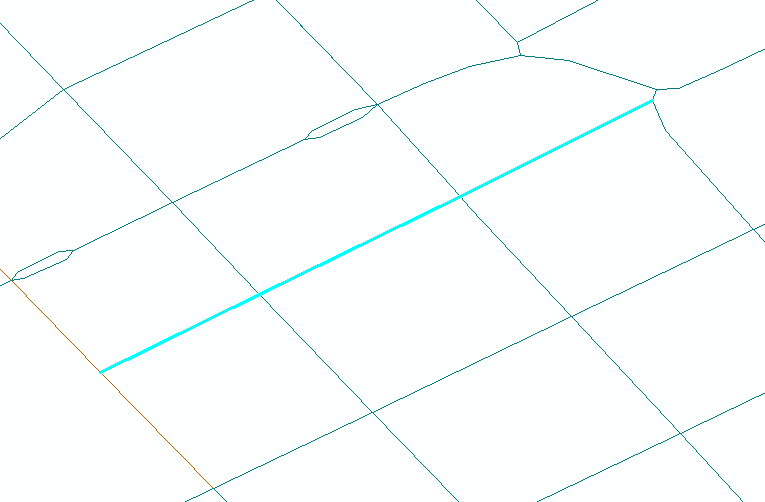

{'matched': {'type': 'FeatureCollection', 'features': []},
 'unmatched': {'type': 'FeatureCollection',
  'features': [{'id': '1',
    'type': 'Feature',
    'properties': {'ROUTE_ID': '1000023965111918-I',
     'THROUGH_LA': 1,
     'SHAPE_Leng': 378.015605153},
    'geometry': {'type': 'LineString',
     'coordinates': [[-93.09361468869884, 44.9485162851479],
      [-93.09247508304765, 44.949070837096215],
      [-93.0910449286703, 44.949769641720735],
      [-93.08967436038594, 44.950452790105544]]}}]},
 'invalid': {'type': 'FeatureCollection', 'features': []}}

In [57]:
# unmatched example 1: downtown St Paul
# source: MnDOT
# 7th Pl E between Minnesota St and N Sibley St
# Sijia - why unmatched: 7th Pl E has directionality change
display(Image(filename = cd + "example2_1.PNG", height=300, width=600))
display(Image(filename = cd + "example2_2.PNG", height=300, width=600))

return_json = match_geom(mndot_input_json[1])
return_json

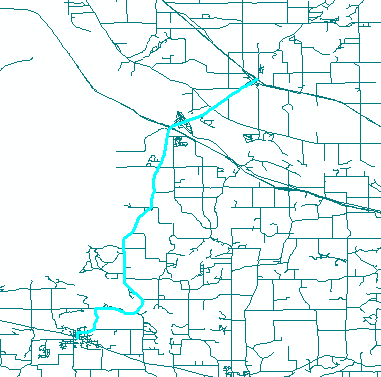

{'message': 'Endpoint request timed out'}

In [58]:
# unmatched example 2: downtown St Paul
# source: MnDOT
# 7th Pl E between Minnesota St and N Sibley St
# Sijia - why failed: link is too long... API request timed out
display(Image(filename = cd + "example3.PNG", height=300, width=300))

return_json = match_geom(mndot_input_json[0])
return_json